In [1]:
name = '2016-10-07-creating-netcdf-datasets'
title = 'Creating NetCDF datasets'
tags = 'netcdf, io'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML, Image

html = connect_notebook_to_post(name, title, tags, author)

### What is NetCDF?

<img src='http://www.unidata.ucar.edu/images/logos/netcdf-50x50.png'>

NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages.

NetCDF data are:

* Self-Describing. A netCDF file includes information about the data it contains.
* Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
* Scalable. A small subset of a large dataset may be accessed efficiently.
* Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
* Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
* Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.

## Opening a file, creating a new Dataset

Let's create an empty NetCDF file named `'../data/new.nc'`, opened for *writing*. Note, opening a file with 'w' will clobber any existing data (unless `clobber=False` is used, in which case an exception is raised if the file already exists).

In [3]:
import os

path_to_file = os.path.join(os.pardir, 'data', 'new.nc')

- `mode='r'` is the default.
- `mode='a'` opens an existing file and allows for appending (does not clobber existing data)
- `format` can be one of
    - `NETCDF3_CLASSIC`
    - `NETCDF3_64BIT`
    - `NETCDF4_CLASSIC`
    - `NETCDF4` (default).

`NETCDF4_CLASSIC` uses HDF5 for the underlying storage layer (as does `NETCDF4`) but enforces the classic netCDF 3 data model so data can be read with older clients.  

### Load essential modules

In [4]:
from __future__ import division, print_function  # py2to3 compatibility
import netCDF4 as nc
import numpy as np
print('NetCDF package version: {}'.format(nc.__version__))

NetCDF package version: 1.2.4


Just to be safe, make sure dataset is not already open

In [5]:
try:
    ncfile.close()
except:
    pass

# another way of checking this:
# if ncfile.isopen():
#     ncfile.close()

ncfile = nc.Dataset(path_to_file, mode='w',
                    format='NETCDF4_CLASSIC') 
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 



### Creating dimensions

The **ncfile** object we created is a container for _dimensions_, _variables_, and _attributes_.   First, let's create some dimensions using the [`createDimension`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createDimension) method.  

- Every dimension has a name and a length.  
- The name is a string that is used to specify the dimension to be used when creating a variable, and as a key to access the dimension object in the `ncfile.dimensions` dictionary.

Setting the dimension length to `0` or `None` makes it unlimited, so it can grow. 

- For `NETCDF4` files, any variable's dimension can be unlimited.  
- For `NETCDF4_CLASSIC` and `NETCDF3*` files, only one per variable can be unlimited, and it must be the leftmost (slowest varying) dimension.

#### Decide what dimensions our data will have

In [6]:
nlat = 73
nlon = 144

In [7]:
lat_dim = ncfile.createDimension('lat', nlat)  # latitude axis
lon_dim = ncfile.createDimension('lon', nlon)  # longitude axis
time_dim = ncfile.createDimension('time', None)  # unlimited axis
for dim in ncfile.dimensions.items():
    print(dim)

('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 73
)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144
)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)


#### Creating attributes

netCDF attributes can be created just like you would for any python object. 

- Best to adhere to established conventions (like the [CF](http://cfconventions.org/) conventions)
- We won't try to adhere to any specific convention here though.

In [8]:
ncfile.author = 'UEA Python Group'
ncfile.title='My model data'
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    author: UEA Python Group
    title: My model data
    dimensions(sizes): lat(73), lon(144), time(0)
    variables(dimensions): 
    groups: 



You can also easily delete a netCDF attribute of a Dataset by using `delncattr` method:

In [9]:
ncfile.some_unnecessary_attribute = '123456'
ncfile.delncattr('some_unnecessary_attribute')

## Creating variables

Now let's add some variables and store some data in them.  

- A variable has a name, a type, a shape, and some data values.  
- The shape of a variable is specified by a tuple of dimension names.  
- A variable should also have some named attributes, such as 'units', that describe the data.

The [`createVariable`](http://unidata.github.io/netcdf4-python/netCDF4.Dataset-class.html#createVariable) method takes 3 mandatory args.

- the 1st argument is the variable name (a string). This is used as the key to access the variable object from the `variables` dictionary.
- the 2nd argument is the datatype (most numpy datatypes supported).  
- the third argument is a tuple containing the dimension names (the dimensions must be created first).  Unless this is a `NETCDF4` file, any unlimited dimension must be the leftmost one.
- there are lots of optional arguments (many of which are only relevant when `format='NETCDF4'`) to control compression, chunking, fill_value, etc.

In [10]:
# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
#
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
#
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'hours since 1800-01-01'
time.long_name = 'time'

#### Define a 3D variable to hold the data

In [11]:
temp = ncfile.createVariable('temp', np.float64,
                             ('time', 'lat', 'lon'))  # note: unlimited dimension is leftmost
temp.units = 'K'  # degrees Kelvin
temp.standard_name = 'air_temperature'  # this is a CF standard name
print(temp)

<class 'netCDF4._netCDF4.Variable'>
float64 temp(time, lat, lon)
    units: K
    standard_name: air_temperature
unlimited dimensions: time
current shape = (0, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used



#### Pre-defined variable attributes (read only)

The netCDF4 module provides some useful pre-defined Python attributes for netCDF variables, such as dimensions, shape, dtype, ndim. 

Note: since no data has been written yet, the length of the 'time' dimension is 0.

In [12]:
print("Some pre-defined attributes for variable temp:\n")
print("temp.dimensions:", temp.dimensions)
print("temp.shape:", temp.shape)
print("temp.dtype:", temp.dtype)
print("temp.ndim:", temp.ndim)

Some pre-defined attributes for variable temp:

temp.dimensions: ('time', 'lat', 'lon')
temp.shape: (0, 73, 144)
temp.dtype: float64
temp.ndim: 3


## Writing data

To write data a netCDF variable object, just treat it like a numpy array and assign values to a slice.

In [13]:
# Write latitudes, longitudes.
# Note: the ":" is necessary in these "write" statements
lat[:] = -90. + (180 / nlat) * np.arange(nlat) # south pole to north pole
lon[:] = (180 / nlat) * np.arange(nlon) # Greenwich meridian eastward

In [14]:
ntimes = 5  # 5 Time slices to begin with

In [15]:
# create a 3D array of random numbers
data_arr = np.random.uniform(low=280, high=330, size=(ntimes, nlat, nlon))
# Write the data. This writes the whole 3D netCDF variable all at once.
temp[:] = data_arr  # Appends data along unlimited dimension

- You can just treat a netCDF Variable object like a numpy array and assign values to it.
- However, unlike numpy arrays, variables automatically grow along unlimited dimensions
- The above writes the whole 3D variable all at once, but you can write it a slice at a time instead.

Let's add another time slice....

In [16]:
# create a 2D array of random numbers
data_slice = np.random.uniform(low=270, high=290, size=(nlat, nlon))
temp[5, :, :] = data_slice  # Appends the 6th time slice
print(" Wrote more data, temp.shape is now ", temp.shape)

 Wrote more data, temp.shape is now  (6, 73, 144)


Note that we have not yet written any data to the time variable.  It automatically grew as we appended data along the time dimension to the variable `temp`, but the data are missing.

In [17]:
print(time)
times_arr = time[:]
print(type(times_arr), times_arr)

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: hours since 1800-01-01
    long_name: time
unlimited dimensions: time
current shape = (6,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'numpy.ma.core.MaskedArray'> [-- -- -- -- -- --]


Dashes indicate masked values (where data have not yet been written).

Now, to work with time objects we will need some extra imports:

In [18]:
import datetime as dt
from netCDF4 import date2num, num2date

In [19]:
# 1st 6 days of October.
dates = [dt.datetime(2016, 10, 1, 0),
         dt.datetime(2016, 10, 2, 0),
         dt.datetime(2016, 10, 3, 0),
         dt.datetime(2016, 10, 4, 0),
         dt.datetime(2016, 10, 5, 0),
         dt.datetime(2016, 10, 6, 0)]
print('\n'.join([str(i) for i in dates]))

2016-10-01 00:00:00
2016-10-02 00:00:00
2016-10-03 00:00:00
2016-10-04 00:00:00
2016-10-05 00:00:00
2016-10-06 00:00:00


In [20]:
times = date2num(dates, time.units)
print(times, time.units) # numeric values
time[:] = times
# read time data back, convert to datetime instances, check values.
print(num2date(time[:], time.units))

[ 1899984.  1900008.  1900032.  1900056.  1900080.  1900104.] hours since 1800-01-01
[datetime.datetime(2016, 10, 1, 0, 0) datetime.datetime(2016, 10, 2, 0, 0)
 datetime.datetime(2016, 10, 3, 0, 0) datetime.datetime(2016, 10, 4, 0, 0)
 datetime.datetime(2016, 10, 5, 0, 0) datetime.datetime(2016, 10, 6, 0, 0)]


## Closing a netCDF file

It's **important** to close a netCDF file you opened for writing:

- flushes buffers to make sure all data gets written
- releases memory resources used by open netCDF files

In [21]:
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    author: UEA Python Group
    title: My model data
    dimensions(sizes): lat(73), lon(144), time(6)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float64 temp(time,lat,lon)
    groups: 



Check again using ncdump utility

In [22]:
!ncdump -h ../data/new.nc

netcdf new {
dimensions:
	lat = 73 ;
	lon = 144 ;
	time = UNLIMITED ; // (6 currently)
variables:
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "latitude" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "longitude" ;
	double time(time) ;
		time:units = "hours since 1800-01-01" ;
		time:long_name = "time" ;
	double temp(time, lat, lon) ;
		temp:units = "K" ;
		temp:standard_name = "air_temperature" ;

// global attributes:
		:author = "UEA Python Group" ;
		:title = "My model data" ;
}


-------------------

## Appending data to NetCDF dataset

In [23]:
ncfile = nc.Dataset(path_to_file, 'a')

In [24]:
temp_ave = ncfile.createVariable('zonal_mean_temp',
                                 np.float64, ('time', 'lat'))
temp_ave.units = 'K'
temp_ave.standard_name = 'zonally_averaged_air_temperature'

In [25]:
print(temp_ave)

<class 'netCDF4._netCDF4.Variable'>
float64 zonal_mean_temp(time, lat)
    units: K
    standard_name: zonally_averaged_air_temperature
unlimited dimensions: time
current shape = (6, 73)
filling on, default _FillValue of 9.969209968386869e+36 used



Create an averaged array using the existing "air_temperature" field:

In [26]:
temp = ncfile.variables['temp'][:]
print(temp.shape)
ave_arr = np.mean(temp[:], axis=2)
print(ave_arr.shape)

(6, 73, 144)
(6, 73)


Write the data

In [27]:
temp_ave[:] = ave_arr  # again, note the square brackets!

In [28]:
ncfile.close()

## Open the resulting dataset and plot some data

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

Open the file for *reading*

In [30]:
ncfile = nc.Dataset(path_to_file, 'r')

First, try this handy methods of extracting variables: [`get_variables_by_attributes`](http://unidata.github.io/netcdf4-python/#netCDF4.Dataset.get_variables_by_attributes). Note: it's available in netCDF4>1.2.0.

In [31]:
try:
    ncfile.get_variables_by_attributes(units='K')
    ncfile.get_variables_by_attributes(ndim=1)
except:
    pass

In [32]:
t = ncfile.variables['zonal_mean_temp']
lats = ncfile.variables['lat']
times = ncfile.variables['time']
dt = num2date(times[:], times.units)

Here is the plot


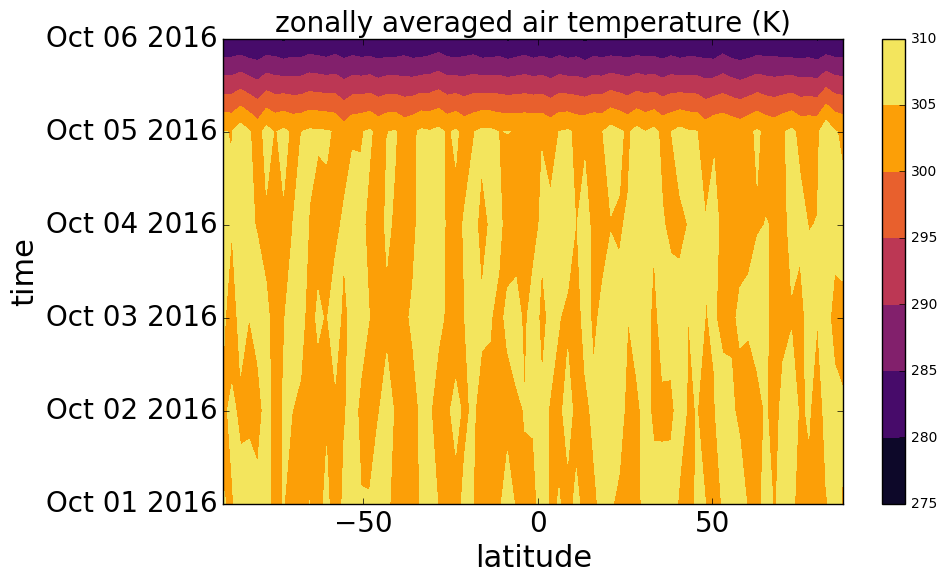

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
p = ax.contourf(lats[:], dt, t[:], cmap='inferno')
cb = fig.colorbar(p, ax=ax)
ax.tick_params(labelsize=20)
ax.set_xlabel(lats.long_name, fontsize=22)
ax.set_ylabel(times.long_name, fontsize=22)
ax.set_title('{} ({})'.format(t.standard_name.replace('_', ' '), t.units), fontsize=20)
print('Here is the plot')

--------------------------

# References

This notebook is build upon the great materials of the [Unidata Python Workshop](https://unidata.github.io/unidata-python-workshop/):
  * https://github.com/Unidata/unidata-python-workshop/blob/master/notebooks/netCDF-Writing.ipynb

## Other interesting and useful projects using netcdf4-python

- [xarray](http://xarray.pydata.org): N-dimensional variant of the core [pandas](http://pandas.pydata.org) data structure that can operate on netcdf variables.
- [Iris](http://scitools.org.uk/iris/): their data model creates a data abstraction layer which isolates analysis and visualisation code from data format specifics.  Can also handle GRIB and PP formats.
- [Biggus](https://github.com/SciTools/biggus): Virtual [large](https://www.youtube.com/watch?v=zPGb4STRfKw) arrays (from netcdf variables) with lazy evaluation.
- [cf-python](http://cfpython.bitbucket.org/): Implements the [CF](http://cfconventions.org) data model for the reading, writing and processing of data and metadata. 

In [34]:
HTML(html)